In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

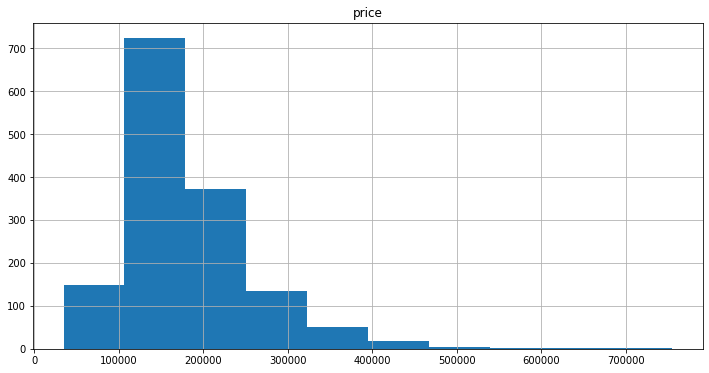

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"]})
prices.hist()

In [6]:
train['SalePrice'] = np.log1p(train['SalePrice'])

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

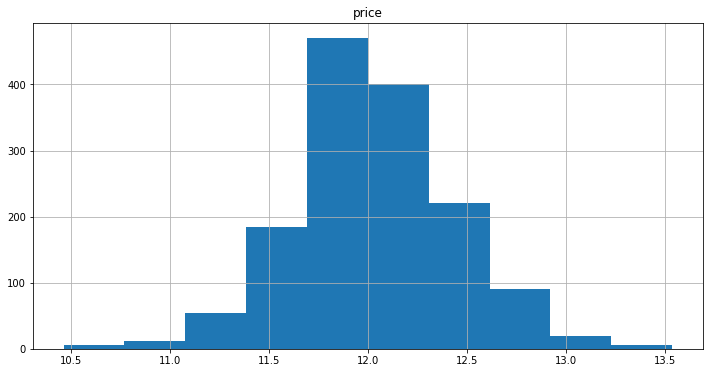

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"]})
prices.hist()

In [8]:
num_features = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_features = train[num_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [9]:
all_data_na = all_data.isnull().sum()
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Data':all_data_na})
missing_data.head(30)

,Missing Data
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageQual,159
GarageCond,159
GarageYrBlt,159


In [10]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
all_data_2 =all_data.drop(all_data.columns.difference(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']),1)
all_data_2.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,FullBath,GarageCars
0,7,2003,6.753438,7.444833,2,2.0
1,6,1976,7.141245,7.141245,2,2.0
2,7,2001,6.825460,7.488294,2,2.0
3,7,1915,6.629363,7.448916,1,3.0
4,8,2000,7.044033,7.695758,2,3.0


In [11]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
X_train_2 = all_data_2[:train.shape[0]]
X_test_2 = all_data_2[train.shape[0]:]
y = train.SalePrice

In [12]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators = 1000)
model.fit(X_train_2, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [13]:
predictions = np.expm1(model.predict(X_test_2))

In [14]:
solution = pd.DataFrame({'Id':test.Id, 'SalePrice':predictions})
solution.to_csv("output.csv", index=False)